<a href="https://colab.research.google.com/github/casaArseniy/AhoyHacks-PirateGame/blob/main/ML_VideoMaskClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OS-CMR SAX Single Slice

*   HEALTHY VS ICMP
*   3D CNN neural network
*   60/20/20 split (training/validation/testing) => 72/24/24 cases each
*   10 epochs
*   Training data is augmented
*   Testing accuracy is 87.5%





## Testing Initial Image Data (Mask x Image)

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image

In [57]:
mask_directory = "/content/drive/MyDrive/CMR Thesis/Healthy_final/BIO0410005/RUN_2024-02-22T11-53-47/Post-HV_Breath-Hold/MaskData/MyocardiumMasks/"
mask_files = os.listdir(mask_directory)
mask_files = [mask_directory+file for file in mask_files if os.path.isfile(os.path.join(mask_directory, file))]

image_directory = "/content/drive/MyDrive/CMR Thesis/Healthy_final/BIO0410005/RUN_2024-02-22T11-53-47/Post-HV_Breath-Hold/ImageData/"
image_files = os.listdir(image_directory)
image_files = [image_directory+file for file in image_files if os.path.isfile(os.path.join(image_directory, file))]

def my_digit_sort(my_list):
  pre_op, postfix = my_list.split('s0p')
  op, unwanted = postfix.split('_')
  return int(op)

In [58]:
image_files.sort(key = my_digit_sort)
mask_files.sort(key = my_digit_sort)

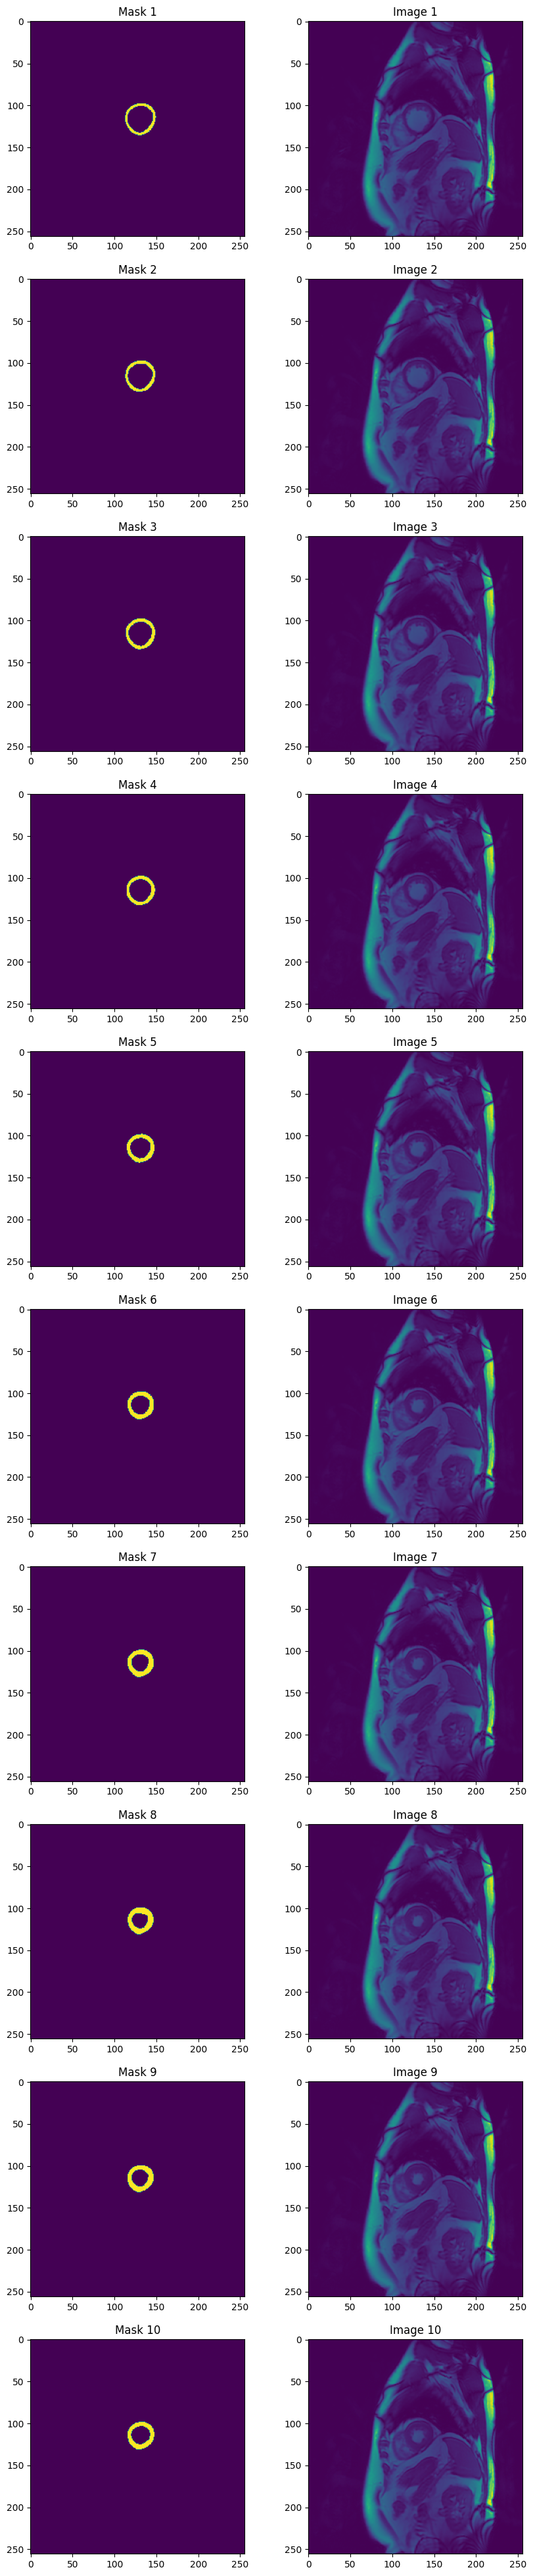

In [132]:
import PIL
import PIL.Image

plt.figure(figsize=(10,50))

for i in range(10):
  img = PIL.Image.open(mask_files[i])
  mask = PIL.Image.open(image_files[i])

  plt.subplot(10, 2, i*2+1)
  plt.imshow(img)
  plt.title(f'Mask {i+1}')

  plt.subplot(10, 2, i*2+2)
  plt.imshow(mask)
  plt.title(f'Image {i+1}')

plt.show()

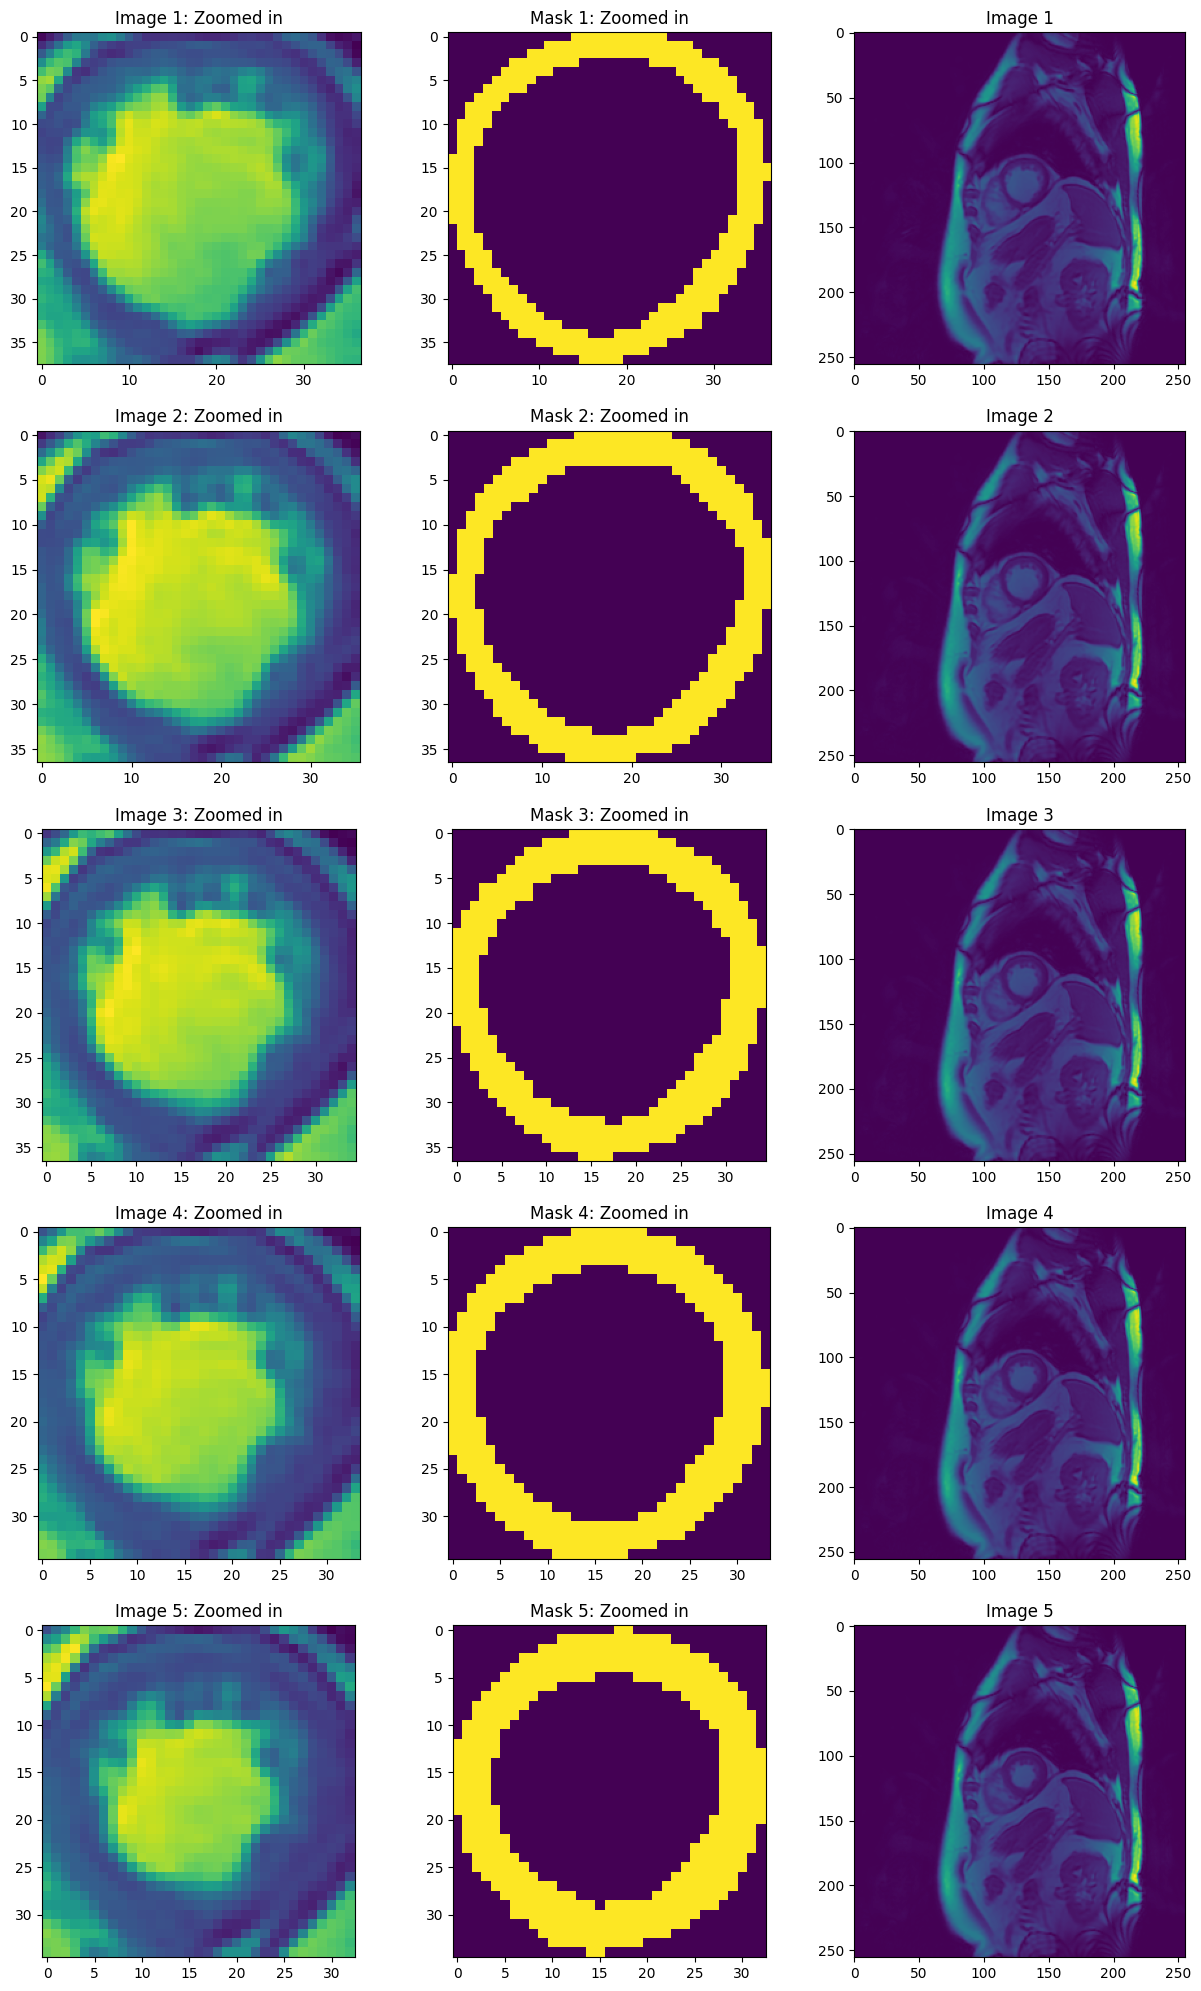

In [145]:
N_rows = 5
N_cols = 3

plt.figure(figsize=(15,5*N_rows))

for i in range(N_rows):
  img = PIL.Image.open(image_files[i])
  mask = PIL.Image.open(mask_files[i])

  img_array = np.array(img)
  mask_array = np.array(mask)

  coordinates_255 = np.argwhere(mask_array == 255)

  # Find maximum and minimum x and y values
  max_x = np.max(coordinates_255[:, 0])
  min_x = np.min(coordinates_255[:, 0])
  max_y = np.max(coordinates_255[:, 1])
  min_y = np.min(coordinates_255[:, 1])

  new_img = img_array[min_x:max_x+1, min_y:max_y+1]
  new_mask = mask_array[min_x:max_x+1, min_y:max_y+1]

  plt.subplot(N_rows, N_cols, i*N_cols+1)
  plt.imshow(new_img)
  plt.title(f'Image {i+1}: Zoomed in')

  plt.subplot(N_rows, N_cols, i*N_cols+2)
  plt.imshow(new_mask)
  plt.title(f'Mask {i+1}: Zoomed in')

  plt.subplot(N_rows, N_cols, i*N_cols+3)
  plt.imshow(img_array)
  plt.title(f'Image {i+1}')

plt.show()

## 3D CNN Neural Network

### Imports

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import imageio
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.15.0


### Preprocess data

In [3]:
healthy_data_dir = '/content/drive/MyDrive/CMR Thesis/Healthy_final/'
Healthy_MyocardiumMasks = tf.data.Dataset.list_files((str(healthy_data_dir)+'*/*/*/MaskData/MyocardiumMasks'), shuffle=False)
Healthy_ImageData = tf.data.Dataset.list_files((str(healthy_data_dir)+'*/*/*/ImageData/'), shuffle=False)

icmp_data_dir = '/content/drive/MyDrive/CMR Thesis/ICMP_final/'
ICMP_MyocardiumMasks = tf.data.Dataset.list_files((str(icmp_data_dir)+'*/*/*/MaskData/MyocardiumMasks'), shuffle=False)
ICMP_ImageData = tf.data.Dataset.list_files((str(icmp_data_dir)+'*/*/*/ImageData/'), shuffle=False)

In [301]:
def mask_squares_from_images(image_files,mask_files):

  new_imgs = []

  for i in range(len(image_files)):
    img = PIL.Image.open(image_files[i])
    mask = PIL.Image.open(mask_files[i])

    img_array = np.array(img)
    mask_array = np.array(mask)

    coordinates_255 = np.argwhere(mask_array == 255)

    # Find maximum and minimum x and y values
    max_x = np.max(coordinates_255[:, 0])
    min_x = np.min(coordinates_255[:, 0])
    max_y = np.max(coordinates_255[:, 1])
    min_y = np.min(coordinates_255[:, 1])

    new_img = img_array[min_x:max_x+1, min_y:max_y+1]

    target_size = (60, 60)
    padded_img = np.ones(target_size)
    padded_img[:new_img.shape[0], :new_img.shape[1]] = new_img

    new_imgs.append(padded_img)

  return np.array(new_imgs)

In [302]:
def case_stack(f, g):
  masks_tf = tf.data.Dataset.list_files(str(f.numpy().decode('utf-8')+'/*'), shuffle = False)
  masks_arr = [z.numpy().decode('utf-8') for z in masks_tf]
  masks_arr.sort(key = my_digit_sort)

  images_tf = tf.data.Dataset.list_files(str(g.numpy().decode('utf-8')+'/*'), shuffle = False)
  images_arr = [z.numpy().decode('utf-8') for z in images_tf]
  images_arr.sort(key = my_digit_sort)
  new_imgs = mask_squares_from_images(images_arr, masks_arr)

  return np.stack(new_imgs)

In [321]:
def save_stacks(masks_tf, images_tf, label):
  output_file_dir = '/content/drive/MyDrive/DL_CMR/'
  case_index = 1
  for f, g in zip(masks_tf, images_tf):
    output_file = output_file_dir + f'{label}/{case_index}.npy'
    # output_file = output_file_dir + f'{label}/{case_index}.gif'
    stack = case_stack(f,g)
    np.save(output_file, stack)
    # imageio.mimsave(output_file, stack)
    print(f'\rCompletion status: {case_index}/60', end='', flush=True)
    case_index += 1



In [322]:
save_stacks(Healthy_MyocardiumMasks, Healthy_ImageData, 'Healthy')

Completion status: 60/60

In [323]:
save_stacks(ICMP_MyocardiumMasks, ICMP_ImageData, 'ICMP')

Completion status: 60/60

### Load and Check Data

In [4]:
def check_files(files):
  case_index = 1
  length  = len(files)
  for f in files:
    case_t = np.load(f.numpy().decode('utf-8'))
    if case_t.shape != (20,60,60):
      print('\n')
      print('----------------------------')
      print('File: ' +  f.numpy().decode('utf-8') + ' not (20,60,60)')
      print(f'Is instead: {case_t.shape}')
      print('----------------------------')
      print('\n')
    print(f'\rCompletion status: {case_index}/{length}', end='', flush=True)
    case_index +=1

In [61]:
files = tf.data.Dataset.list_files('/content/drive/MyDrive/DL_CMR_NP/ICMP_NP/*', shuffle=False)
check_files(files)

files = tf.data.Dataset.list_files('/content/drive/MyDrive/DL_CMR_NP/Healthy_NP/*', shuffle=False)
check_files(files)

Completion status: 25/60

----------------------------
File: /content/drive/MyDrive/DL_CMR_NP/ICMP_NP/32.npy not (20,60,60)
Is instead: (21, 60, 60)
----------------------------


Completion status: 60/60

In [29]:
def load_data_and_label(index):
    if index <= 60:
      data =  np.load(f'/content/drive/MyDrive/DL_CMR_NP/Healthy_NP/{index}.npy')
      label = 0
    else:
      index = index - 60
      data =  np.load(f'/content/drive/MyDrive/DL_CMR_NP/ICMP_NP/{index}.npy')
      label = 1

      if data.shape[0] > 20:
        data = data[0:20 :, :]

    return data, label

# Function to flip the data
def flip_data_left_right(data, label):
    # Flip along the vertical axis
    data = tf.convert_to_tensor(data)
    data = tf.image.flip_left_right(data)
    return data, label

def flip_data_up_down(data, label):
  data = tf.convert_to_tensor(data)
  data = tf.image.flip_up_down(data)
  return data, label



num_samples = 121
indices = tf.data.Dataset.range(1, num_samples)
dataset = indices.map(lambda x: tf.numpy_function(load_data_and_label, [x], (tf.double, tf.int64)))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=num_samples)  # Shuffle the dataset

# Define the split ratio
split_ratio = 0.6
val_ratio = 0.2

train_size = int(split_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = num_samples - train_size - val_size

# Split the dataset into train and test datasets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
print("Size of initial train dataset:", train_dataset_size)
train_dataset = train_dataset.concatenate(train_dataset.map(flip_data_left_right).take(train_dataset_size))

train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
train_dataset = train_dataset.concatenate(train_dataset.map(flip_data_up_down).take(train_dataset_size))

train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_dataset_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_dataset_size = tf.data.experimental.cardinality(test_dataset).numpy()


print("Size of augmented train dataset:", train_dataset_size)
print("Size of train dataset:", val_dataset_size)
print("Size of train dataset:", test_dataset_size)



# Batch the datasets
batch_size = 16 # 8, 16, 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

Size of initial train dataset: 72
Size of augmented train dataset: 288
Size of train dataset: 24
Size of train dataset: 24


In [3]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Now you can iterate over the dataset in your training loop
for batch_data, batch_labels in train_dataset:
  print(batch_data.shape)
  print(batch_labels)

(16, 20, 60, 60)
tf.Tensor([0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0], shape=(16,), dtype=int64)
(16, 20, 60, 60)
tf.Tensor([0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1], shape=(16,), dtype=int64)
(16, 20, 60, 60)
tf.Tensor([0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1], shape=(16,), dtype=int64)
(16, 20, 60, 60)
tf.Tensor([0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0], shape=(16,), dtype=int64)
(16, 20, 60, 60)
tf.Tensor([1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1], shape=(16,), dtype=int64)
(16, 20, 60, 60)
tf.Tensor([0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 0], shape=(16,), dtype=int64)
(16, 20, 60, 60)
tf.Tensor([1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1], shape=(16,), dtype=int64)
(16, 20, 60, 60)
tf.Tensor([1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1], shape=(16,), dtype=int64)
(16, 20, 60, 60)
tf.Tensor([0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0], shape=(16,), dtype=int64)
(16, 20, 60, 60)
tf.Tensor([1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0], shape=(16,), dtype=int64)
(16, 20, 60, 60)
tf.Tensor([1 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1], shape=(16,), dtype=int64)
(16, 20, 60, 60)
tf.Tensor([1 0 

In [8]:
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Now you can iterate over the dataset in your training loop
for batch_data, batch_labels in test_dataset:
  print(batch_data.shape)
  print(batch_labels)

(16, 20, 60, 60)
tf.Tensor([1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1], shape=(16,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([0 1 0 1 0 1 1 0], shape=(8,), dtype=int64)


In [14]:
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Now you can iterate over the dataset in your training loop
for batch_data, batch_labels in val_dataset:
  print(batch_data.shape)
  print(batch_labels)

(16, 20, 60, 60)
tf.Tensor([0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0], shape=(16,), dtype=int64)
(8, 20, 60, 60)
tf.Tensor([1 0 0 1 0 0 0 0], shape=(8,), dtype=int64)


### Model

In [23]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(20, 60, 60, 1)),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'],
              run_eagerly=True)

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 18, 58, 58, 32)    896       
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 9, 29, 29, 32)     0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 9, 29, 29, 64)     55360     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 4, 14, 14, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 2, 12, 12, 128)    221312    
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 1, 6, 6, 128)     

In [24]:
train_dataset = train_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))
test_dataset = test_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))
val_dataset = val_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))

In [25]:
for x, y in val_dataset:
    shape_x = x.shape
    shape_y = y.shape
    print("Shape of input data:", shape_x)
    print("Shape of labels:", shape_y)


Shape of input data: (16, 20, 60, 60, 1)
Shape of labels: (16,)
Shape of input data: (8, 20, 60, 60, 1)
Shape of labels: (8,)


In [26]:
# Define number of epochs
epochs = 10

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,  # Number of epochs with no improvement
    restore_best_weights=True  # Restore model weights to the best observed during training
)

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)


# Fit the model
# model.fit(train_dataset, epochs=epochs)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
18/18 [==============================] - 116s 6s/step - loss: 4.3475 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.6250
Epoch 2/10
18/18 [==============================] - 113s 6s/step - loss: 0.5575 - accuracy: 0.7569 - val_loss: 0.4551 - val_accuracy: 0.7500
Epoch 3/10
18/18 [==============================] - 118s 6s/step - loss: 0.4150 - accuracy: 0.8368 - val_loss: 0.5502 - val_accuracy: 0.6667
Epoch 4/10
18/18 [==============================] - 119s 7s/step - loss: 0.4020 - accuracy: 0.8368 - val_loss: 0.2107 - val_accuracy: 0.9583
Epoch 5/10
18/18 [==============================] - 116s 6s/step - loss: 0.3267 - accuracy: 0.8924 - val_loss: 0.5008 - val_accuracy: 0.8333
Epoch 6/10
18/18 [==============================] - 120s 7s/step - loss: 0.2813 - accuracy: 0.8958 - val_loss: 0.2803 - val_accuracy: 0.9167
Epoch 7/10
2/2 [==============================] - 3s 988ms/step - loss: 0.4627 - accuracy: 0.8750
Test Loss: 0.46270284056663513
Test Accuracy: 0.875


In [27]:
model.save_weights('/content/drive/MyDrive/DL_CMR_WEIGHTS/model_weights_60_20_20.h5')